In [1]:
# General Imports
import os
import numpy as np
import pandas as pd
from time import strftime, localtime
import matplotlib.pyplot as plt
import seaborn as sn

# Deep Learning
import tensorflow as tf


from sklearn.metrics import cohen_kappa_score,f1_score,accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, \
    hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import check_random_state

plt.rcParams.update({'font.size': 22})
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

#TODO: fix directories
SOURCE_PATH = "/srv/workspace/research/user_based_contexts_tagging/"
SPECTROGRAMS_PATH = "/srv/workspace/research/user_based_contexts_tagging/dataset/"
OUTPUT_PATH = "/srv/workspace/research/user_based_contexts_tagging/experiments_results/"
EXTRA_OUTPUTS = "/srv/workspace/research/extra_experiment_results"


EXPERIMENTNAME = "single_label_deeper_weighted_normalized_long"
INPUT_SHAPE = (646, 96, 1)
EMBEDDINGS_DIM = 256
#TODO: fix labels
LABELS_LIST = ['car', 'gym', 'happy', 'night', 'relax',
       'running', 'sad', 'summer', 'work', 'workout']

global_user_embeddings = pd.read_pickle("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/user_embeddings.pkl")
global_labels = pd.read_csv("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/all_labels_clipped.csv")
train_partial = pd.read_csv("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/train_single.csv")
POS_WEIGHTS = len(train_partial)/train_partial.sum()[2:]
POS_WEIGHTS = [np.float32(x) for x in POS_WEIGHTS]

BATCH_SIZE = 32

from tensorflow.keras.backend import set_session


def limit_memory_usage(gpu_memory_fraction=0.1):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_fraction
    set_session(tf.Session(config=config))


limit_memory_usage(0.3)
def dataset_from_csv(csv_path, **kwargs):
    """
        Load dataset from a csv file.
        kwargs are forwarded to the pandas.read_csv function.
    """
    df = pd.read_csv(csv_path, **kwargs)

    dataset = (
        tf.data.Dataset.from_tensor_slices(
            {
                key:df[key].values
                for key in df
            }
        )
    )
    return dataset

def set_tensor_shape(tensor, tensor_shape):
        """
            set shape for a tensor (not in place, as opposed to tf.set_shape)
        """
        tensor.set_shape(tensor_shape)
        return tensor

def check_tensor_shape(tensor_tf, target_shape):
    """
        Return a Tensorflow boolean graph that indicates whether sample[features_key] has the specified target shape
        Only check not None entries of target_shape.
    """
    res = tf.constant(True)
    for idx,target_length in enumerate(target_shape):
        if target_length:
            res = tf.logical_and(res, tf.equal(tf.constant(target_length), tf.shape(tensor_tf)[idx]))

    return res
def load_spectrogram(*args):
    """
        loads spectrogram with error tracking.
        args : song ID, path to dataset
        return:
            Features: numpy ndarray, computed features (if no error occured, otherwise: 0)
            Error: boolean, False if no error, True if an error was raised during features computation.
    """
    # TODO: edit path
    path = SPECTROGRAMS_PATH
    song_id, dummy_path = args
    try:
        # tf.logging.info(f"Load spectrogram for {song_id}")
        spect = np.load(os.path.join(path, "mels" + str(song_id) + '.npz'))['arr_0']
        if (spect.shape != (1, 646, 96)):
            # print("\n Error while computing features for" +  str(song_id) + '\n')
            return np.float32(0.0), True
            # spect = spect[:,215:215+646]
        # print(spect.shape)
        return spect, False
    except Exception as err:
        # print("\n Error while computing features for " + str(song_id) + '\n')
        return np.float32(0.0), True

def load_spectrogram_tf(sample, identifier_key="song_id",
                        path="/my_data/MelSpectograms_top20/", device="/cpu:0",
                        features_key="features"):
    """
        wrap load_spectrogram into a tensorflow function.
    """
    with tf.device(device):
        input_args = [sample[identifier_key], tf.constant(path)]
        res = tf.py_func(load_spectrogram,
                         input_args,
                         (tf.float32, tf.bool),
                         stateful=False),
        spectrogram, error = res[0]

        res = dict(list(sample.items()) + [(features_key, spectrogram), ("error", error)])
        return res


# Dataset pipelines
def get_embeddings_py(sample_user_id):
    user_embeddings = global_user_embeddings[global_user_embeddings.user_id == sample_user_id]
    samples_user_embeddings = user_embeddings.iloc[:, 1:].values.flatten()
    samples_user_embeddings = np.asarray(samples_user_embeddings[0])
    samples_user_embeddings = samples_user_embeddings.astype(np.float32)
    return samples_user_embeddings


def tf_get_embeddings_py(sample, device="/cpu:0"):
    with tf.device(device):
        input_args = [sample["user_id"]]
        user_embeddings = tf.py_func(get_embeddings_py,
                                                        input_args,
                                                        [tf.float32],
                                                        stateful=False)
        res = dict(
            list(sample.items()) + [("user_embeddings", user_embeddings)])
        return res

# Dataset pipelines
def get_labels_py(song_id,user_id):
    labels = global_labels[global_labels.song_id == song_id][global_labels.user_id == user_id]
    labels = labels.iloc[:, 2:].values.flatten() # TODO: fix this shift in dataframe columns when read
    labels = labels.astype(np.float32)
    return labels


def tf_get_labels_py(sample, device="/cpu:0"):
    with tf.device(device):
        input_args = [sample["song_id"],sample["user_id"]]
        labels = tf.py_func(get_labels_py,
                            input_args,
                            [tf.float32],
                            stateful=False)
        res = dict(list(sample.items()) + [("binary_label", labels)])
        return res


def get_dataset(input_csv, input_shape=INPUT_SHAPE, batch_size=32, shuffle=True,
                infinite_generator=True, random_crop=False, cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/"),
                num_parallel_calls=32):
    # build dataset from csv file
    dataset = dataset_from_csv(input_csv)
    # Shuffle data
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100, seed=1, reshuffle_each_iteration=True)

    # compute mel spectrogram
    dataset = dataset.map(lambda sample: load_spectrogram_tf(sample), num_parallel_calls=1)

    # filter out errors
    dataset = dataset.filter(lambda sample: tf.logical_not(sample["error"]))

    # map dynamic compression
    C = 100
    dataset = dataset.map(lambda sample: dict(sample, features=tf.log(1 + C * sample["features"])),
                          num_parallel_calls=num_parallel_calls)

    # Apply permute dimensions
    dataset = dataset.map(lambda sample: dict(sample, features=tf.transpose(sample["features"], perm=[1, 2, 0])),
                          num_parallel_calls=num_parallel_calls)

    # Filter by shape (remove badly shaped tensors)
    dataset = dataset.filter(lambda sample: check_tensor_shape(sample["features"], input_shape))

    # set features shape
    dataset = dataset.map(lambda sample: dict(sample,
                                              features=set_tensor_shape(sample["features"], input_shape)))

    # if cache_dir:
    #    os.makedirs(cache_dir, exist_ok=True)
    #    dataset = dataset.cache(cache_dir)

    dataset = dataset.map(lambda sample: tf_get_labels_py(sample), num_parallel_calls=1)


    # set output shape
    dataset = dataset.map(lambda sample: dict(sample, binary_label=set_tensor_shape(
        sample["binary_label"], (len(LABELS_LIST)))))

    # load embeddings
    dataset = dataset.map(lambda sample: tf_get_embeddings_py(sample), num_parallel_calls=1)
    # set weights shape
    dataset = dataset.map(lambda sample: dict(sample, user_embeddings=set_tensor_shape(
        sample["user_embeddings"], EMBEDDINGS_DIM)))

    if infinite_generator:
        # Repeat indefinitly
        dataset = dataset.repeat(count=-1)

    # Make batch
    dataset = dataset.batch(batch_size)

    # Select only features and annotation
    dataset = dataset.map(lambda sample: (
    sample["features"], sample["binary_label"], sample["user_embeddings"],sample["song_id"],sample["user_id"]))

    return dataset


def get_training_dataset(path):
    return get_dataset(path, shuffle=True,
                       cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/training/"))


def get_validation_dataset(path):
    return get_dataset(path, batch_size=32, shuffle=False,
                       random_crop=False, cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/validation/"))


def get_test_dataset(path):
    return get_dataset(path, batch_size=50, shuffle=False,
                       infinite_generator=False, cache_dir=os.path.join(OUTPUT_PATH, "tmp/tf_cache/test/"))


def load_test_set_raw(LOADING_PATH=os.path.join(SOURCE_PATH, "GroundTruth/"),
                      SPECTROGRAM_PATH=SPECTROGRAMS_PATH):
    # Loading testset groundtruth
    test_ground_truth = pd.read_csv(os.path.join(LOADING_PATH, "test_ground_truth_binarized.csv"))
    all_ground_truth = pd.read_csv(os.path.join(LOADING_PATH, "balanced_ground_truth_hot_vector.csv"))
    # all_ground_truth.drop("playlists_count", axis=1, inplace=True);
    all_ground_truth = all_ground_truth[all_ground_truth.song_id.isin(test_ground_truth.song_id)]
    all_ground_truth = all_ground_truth.set_index('song_id')
    all_ground_truth = all_ground_truth.loc[test_ground_truth.song_id]
    test_classes = all_ground_truth.values
    test_classes = test_classes.astype(int)

    spectrograms = np.zeros([len(test_ground_truth), 646, 96])
    songs_ID = np.zeros([len(test_ground_truth), 1])
    for idx, filename in enumerate(list(test_ground_truth.song_id)):
        try:
            spect = np.load(os.path.join(SPECTROGRAM_PATH, str(filename) + '.npz'))['arr_0']
        except:
            continue
        if (spect.shape == (1, 646, 96)):
            spectrograms[idx] = spect
            songs_ID[idx] = filename

    # Apply same transformation as trianing [ALWAYS DOUBLE CHECK TRAINING PARAMETERS]
    C = 100
    spectrograms = np.log(1 + C * spectrograms)

    spectrograms = np.expand_dims(spectrograms, axis=3)
    return spectrograms, test_classes


def get_weights(shape):
    w = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    # variable_summaries(w)
    return w


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    b = tf.Variable(initial)
    # variable_summaries(b)
    return b


def conv_2d(x, W, name=""):
    return tf.nn.conv2d(x, W, [1, 1, 1, 1], padding="SAME", name=name)


def max_pooling(x, shape, name=""):
    return tf.nn.max_pool(x, shape, strides=[1, 2, 2, 1], padding="SAME", name=name)


def conv_layer_with_relu(input, shape, name=""):
    W = get_weights(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv_2d(input, W, name) + b)


def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = get_weights([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

def get_model(x_input,user_embeddings, current_keep_prob, train_phase):
    # Define model architecture
    # C4_model
    x_norm = tf.layers.batch_normalization(x_input, training=train_phase)
    embeds_norm = tf.layers.batch_normalization(user_embeddings, training=train_phase)


    with tf.name_scope('CNN_1'):
        conv1 = conv_layer_with_relu(x_norm, [3, 3, 1, 32], name="conv_1")
        max1 = max_pooling(conv1, shape=[1, 2, 2, 1], name="max_pool_1")

    with tf.name_scope('CNN_2'):
        conv2 = conv_layer_with_relu(max1, [3, 3, 32, 64], name="conv_2")
        max2 = max_pooling(conv2, shape=[1, 2, 2, 1], name="max_pool_2")

    with tf.name_scope('CNN_3'):
        conv3 = conv_layer_with_relu(max2, [3, 3, 64, 128], name="conv_3")
        max3 = max_pooling(conv3, shape=[1, 2, 2, 1], name="max_pool_3")

    with tf.name_scope('CNN_4'):
        conv4 = conv_layer_with_relu(max3, [3, 3, 128, 256], name="conv_4")
        max4 = max_pooling(conv4, shape=[1, 2, 2, 1], name="max_pool_4")
    """
    with tf.name_scope('CNN_5'):
        conv5 = conv_layer_with_relu(max4, [3, 3, 256, 256], name="conv_5")
        max5 = max_pooling(conv5, shape=[1, 2, 2, 1], name="max_pool_5")

    with tf.name_scope('CNN_6'):
        conv6 = conv_layer_with_relu(max5, [3, 3, 256, 256], name="conv_6")
        max6 = max_pooling(conv6, shape=[1, 2, 2, 1], name="max_pool_6")

    with tf.name_scope('Fully_connected_1'):
        flattened = tf.reshape(max6, [-1, 11 * 2 * 256])
        fully1 = tf.nn.sigmoid(full_layer(flattened, 256))
    """
    with tf.name_scope('embedding_layer_1'):
        embeddings_1 = full_layer(embeds_norm, 128)
        embeds_1_norm = tf.layers.batch_normalization(embeddings_1, training=train_phase)
    """
    with tf.name_scope('flattened_layer_1'):
        flattened = tf.reshape(max4, [-1, 41 * 6 * 256])
        spect_1 = tf.nn.sigmoid(full_layer(flattened, 2048))
        spect_2 = tf.nn.sigmoid(full_layer(spect_1, 256))
        spect_3 = tf.nn.sigmoid(full_layer(spect_2, 128))
    """
    with tf.name_scope('Fully_connected_1'):
        flattened = tf.reshape(max4, [-1, 41 * 6 * 256])
        flattened_norm = tf.layers.batch_normalization(flattened, training=train_phase)
        concatenated = tf.concat([flattened_norm,embeds_1_norm],1)
        fully1 = tf.nn.sigmoid(full_layer(concatenated, 128))


    with tf.name_scope('Fully_connected_2'):
        dropped = tf.nn.dropout(fully1, keep_prob=current_keep_prob)
        logits = full_layer(dropped, len(LABELS_LIST))

    output = tf.nn.softmax(logits)
    tf.summary.histogram('outputs', output)
    return logits, output



def evaluate_model(test_pred_prob, test_classes, saving_path, evaluation_file_path):
    """
    Evaluates a given model using accuracy, area under curve and hamming loss
    :param model: model to be evaluated
    :param spectrograms: the test set spectrograms as an np.array
    :param test_classes: the ground truth labels
    :return: accuracy, auc_roc, hamming_error
    """
    test_pred = np.round(test_pred_prob)
    # Accuracy
    accuracy = 100 * accuracy_score(test_classes, test_pred)
    print("Exact match accuracy is: " + str(accuracy) + "%")
    # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    auc_roc = roc_auc_score(test_classes, test_pred_prob)
    print("Macro Area Under the Curve (AUC) is: " + str(auc_roc))
    auc_roc_micro = roc_auc_score(test_classes, test_pred_prob, average="micro")
    print("Micro Area Under the Curve (AUC) is: " + str(auc_roc_micro))
    auc_roc_weighted = roc_auc_score(test_classes, test_pred_prob, average="weighted")
    print("Weighted Area Under the Curve (AUC) is: " + str(auc_roc_weighted))
    # Hamming loss is the fraction of labels that are incorrectly predicted.
    hamming_error = hamming_loss(test_classes, test_pred)
    print("Hamming Loss (ratio of incorrect tags) is: " + str(hamming_error))
    with open(evaluation_file_path, "w") as f:
        f.write("Exact match accuracy is: " + str(accuracy) + "%\n" + "Area Under the Curve (AUC) is: " + str(auc_roc)
                + "\nMicro AUC is:" + str(auc_roc_micro) + "\nWeighted AUC is:" + str(auc_roc_weighted)
                + "\nHamming Loss (ratio of incorrect tags) is: " + str(hamming_error))
    print("saving prediction to disk")
    np.savetxt(os.path.join(saving_path, 'predictions.out'), test_pred_prob, delimiter=',')
    np.savetxt(os.path.join(saving_path, 'test_ground_truth_classes.txt'), test_classes, delimiter=',')
    return accuracy, auc_roc, hamming_error


def plot_loss_acuracy(epoch_losses_history, epoch_accurcies_history, val_losses_history, val_accuracies_history, path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 10))
    plt.plot(epoch_accurcies_history)
    plt.plot(val_accuracies_history)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(path, "model_accuracy.png"))
    plt.savefig(os.path.join(path, "model_accuracy.pdf"), format='pdf')
    # plt.savefig(os.path.join(path,label + "_model_accuracy.eps"), format='eps', dpi=900)
    # Plot training & validation loss values
    plt.figure(figsize=(10, 10))
    plt.plot(epoch_losses_history)
    plt.plot(val_losses_history)
    plt.title('Model loss (Cross Entropy without weighting)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(path, "model_loss.png"))
    plt.savefig(os.path.join(path, "model_loss.pdf"), format='pdf')
    # plt.savefig(os.path.join(path,label + "_model_loss.eps"), format='eps', dpi=900)


def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


def load_predictions_groundtruth(predictions_path, groundtruth_path):
    test_pred_prob = np.loadtxt(predictions_path, delimiter=',')
    test_classes = np.loadtxt(groundtruth_path, delimiter=',')
    return test_pred_prob, test_classes


def plot_output_coocurances(model_output_rounded, output_path, LABELS_LIST):
    # Getting coocuarances
    test_pred_df = pd.DataFrame(model_output_rounded, columns=LABELS_LIST)
    coocurrances = pd.DataFrame(columns=test_pred_df.columns)
    for column in test_pred_df.columns:
        coocurrances[column] = test_pred_df[test_pred_df[column] == 1].sum()
    coocurrances = coocurrances.T
    # Plotting coocurances
    plt.figure(figsize=(30, 30));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'Number of track coocurances in model output', fontsize=34, ha='center')
    sn.heatmap(coocurrances, annot=True, annot_kws={"size": 24}, fmt='.0f', cmap=cmap);
    plt.savefig(output_path + ".pdf", format="pdf")
    plt.savefig(output_path + ".png")


def plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth, output_path, LABELS_LIST):
    # Getting false negatives coocuarances
    test_pred_df = pd.DataFrame(model_output_rounded, columns=LABELS_LIST)
    test_classes_df = pd.DataFrame(groundtruth, columns=LABELS_LIST)
    FN_coocurrances = pd.DataFrame(columns=test_pred_df.columns)
    for column in test_pred_df.columns:
        FN_coocurrances[column] = test_pred_df[[negative_prediction and positive_sample
                                                for negative_prediction, positive_sample in
                                                zip(test_pred_df[column] == 0, test_classes_df[column] == 1)]].sum()
    FN_coocurrances = FN_coocurrances.T
    # Plotting coocurances
    plt.figure(figsize=(30, 30));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'False negatives confusion matrix', fontsize=34, ha='center')
    sn.heatmap(FN_coocurrances, annot=True, annot_kws={"size": 24}, fmt='.0f', cmap=cmap);
    plt.savefig(output_path + ".pdf", format="pdf")
    plt.savefig(output_path + ".png")


def plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth, output_path, LABELS_LIST):
    # Creating a plot of true positives vs all positives
    true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
    true_positives_df = pd.DataFrame(columns=LABELS_LIST)
    true_positives_df.index.astype(str, copy=False)
    true_positives_df.loc[0] = true_positives_perclass
    percentage_of_positives_perclass = sum(groundtruth)
    true_positives_df.loc[1] = percentage_of_positives_perclass
    true_positives_df.index = ['True Positives', 'Positive Samples']
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
    # Plot the figure
    labels = [label + " (" + "{:.1f}".format(true_positives_ratio_perclass[idx] * 100) + "%) " for idx, label in
              enumerate(LABELS_LIST)]
    true_positives_df.columns = labels
    true_positives_df.T.plot.bar(figsize=(32, 22), fontsize=28)
    plt.xticks(rotation=45)
    plt.title(
        "Number of true positive per class compared to the total number of positive samples \n Average true positive rate: " + "{:.2f}".format(
            true_positives_ratio_perclass.mean()))
    plt.savefig(output_path + ".pdf", format="pdf")
    plt.savefig(output_path + ".png")


def create_analysis_report(model_output, groundtruth, output_path, LABELS_LIST, validation_output=None,
                           validation_groundtruth=None):
    """
    Create a report of all the different evaluation metrics, including optimizing the threshold with the validation set
    if it is passed in the parameters
    """
    # Round the probabilities at 0.5
    model_output_rounded = np.round(model_output)
    model_output_rounded = np.clip(model_output_rounded, 0, 1)
    # Create a dataframe where we keep all the evaluations, starting by prediction accuracy
    accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
    results_df = pd.DataFrame(columns=LABELS_LIST)
    results_df.index.astype(str, copy=False)
    percentage_of_positives_perclass = sum(groundtruth) / len(groundtruth)
    results_df.loc[0] = percentage_of_positives_perclass
    results_df.loc[1] = accuracies_perclass
    results_df.index = ['Ratio of positive samples', 'Model accuracy']

    # plot the accuracies per class
    results_df.T.plot.bar(figsize=(22, 12), fontsize=18)
    plt.title('Model accuracy vs the ratio of positive samples per class')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.pdf"), format="pdf")
    plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.png"))

    # Getting the true positive rate perclass
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
    results_df.loc[2] = true_positives_ratio_perclass
    # Get true negative ratio
    true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                       * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
    results_df.loc[3] = true_negative_ratio_perclass
    # compute additional metrics (AUC,f1,recall,precision)
    auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
    precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
    recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
    f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
    kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in range(len(LABELS_LIST))]
    results_df = results_df.append(
        pd.DataFrame([auc_roc_per_label,recall_perlabel, precision_perlabel, f1_perlabel, kappa_perlabel], columns=LABELS_LIST))
    results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                        'True negatives ratio', "AUC", "Recall", "Precision", "f1-score", "Kappa score"]

    # Creating evaluation plots
    plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth,
                                        os.path.join(output_path, 'TruePositive_vs_allPositives'), LABELS_LIST)
    plot_output_coocurances(model_output_rounded, os.path.join(output_path, 'output_coocurances'), LABELS_LIST)
    plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth,
                                           os.path.join(output_path, 'false_negative_coocurances'), LABELS_LIST)

    # Adjusting threshold based on validation set
    if (validation_groundtruth is not None and validation_output is not None):
        np.savetxt(os.path.join(output_path, 'validation_predictions.out'), validation_output, delimiter=',')
        np.savetxt(os.path.join(output_path, 'valid_ground_truth_classes.txt'), validation_groundtruth, delimiter=',')
        thresholds = np.arange(0, 1, 0.01)
        f1_array = np.zeros((len(LABELS_LIST), len(thresholds)))
        for idx, label in enumerate(LABELS_LIST):
            f1_array[idx, :] = [
                f1_score(validation_groundtruth[:, idx], np.clip(np.round(validation_output[:, idx] - threshold + 0.5), 0, 1))
                for threshold in thresholds]
        threshold_arg = np.argmax(f1_array, axis=1)
        threshold_per_class = thresholds[threshold_arg]

        # plot the f1 score across thresholds
        plt.figure(figsize=(20, 20))
        for idx, x in enumerate(LABELS_LIST):
            plt.plot(thresholds, f1_array[idx, :], linewidth=5)
        plt.legend(LABELS_LIST, loc='best')
        plt.title("F1 Score vs different prediction threshold values for each class")
        plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.pdf"), format="pdf")
        plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.png"))

        # Applying thresholds optimized per class
        model_output_rounded = np.zeros_like(model_output)
        for idx, label in enumerate(LABELS_LIST):
            model_output_rounded[:, idx] = np.clip(np.round(model_output[:, idx] - threshold_per_class[idx] + 0.5), 0, 1)

        accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
        # Getting the true positive rate perclass
        true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(
            groundtruth)
        # Get true negative ratio
        true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                           * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
        results_df = results_df.append(
            pd.DataFrame([accuracies_perclass, true_positives_ratio_perclass,
                          true_negative_ratio_perclass], columns=LABELS_LIST))
        # compute additional metrics (AUC,f1,recall,precision)
        auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
        precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
        recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
        f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
        kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in
                          range(len(LABELS_LIST))]
        results_df = results_df.append(
            pd.DataFrame([auc_roc_per_label, precision_perlabel, recall_perlabel, f1_perlabel,kappa_perlabel],
                         columns=LABELS_LIST))
        results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                            'True negatives ratio', "AUC", "Precision", "Recall", "f1-score",  "Kappa score",
                            'Optimized model accuracy', 'Optimized true positives ratio',
                            'Optimized true negatives ratio', "Optimized AUC",
                            "Optimized precision", "Optimized recall", "Optimized f1-score",  "Optimized Kappa score"]

        # Creating evaluation plots
        plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth,
                                            os.path.join(output_path, 'TruePositive_vs_allPositives[optimized]'),
                                            LABELS_LIST)
        plot_output_coocurances(model_output_rounded, os.path.join(output_path, 'output_coocurances[optimized]'),
                                LABELS_LIST)
        plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth,
                                               os.path.join(output_path, 'false_negative_coocurances[optimized]'),
                                               LABELS_LIST)
    results_df['average'] = results_df.mean(numeric_only=True, axis=1)
    results_df.T.to_csv(os.path.join(output_path, "results_report.csv"), float_format="%.2f")
    return results_df

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Current Experiment: single_label_deeper_weighted_normalized_long



Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Restoring parameters from /srv/workspace/research/extra_experiment_results/single_label_deeper_weighted_normalized_long/2020-05-07_18-19-37/best_validation.ckpt
Model with best validation restored before testing.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Exact match accuracy is: 1.4847417840375587%
Macro Area Under the Curve (AUC) is: 0.6914996657163089
Micro Area Under the Curve (AUC) is: 0.7057591950890018
Weighted Area Under the Curve (AUC) is: 0.6941805922535977
Hamming Loss (ratio of incorrect tags) is: 0.09979655712050078
saving prediction to disk


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


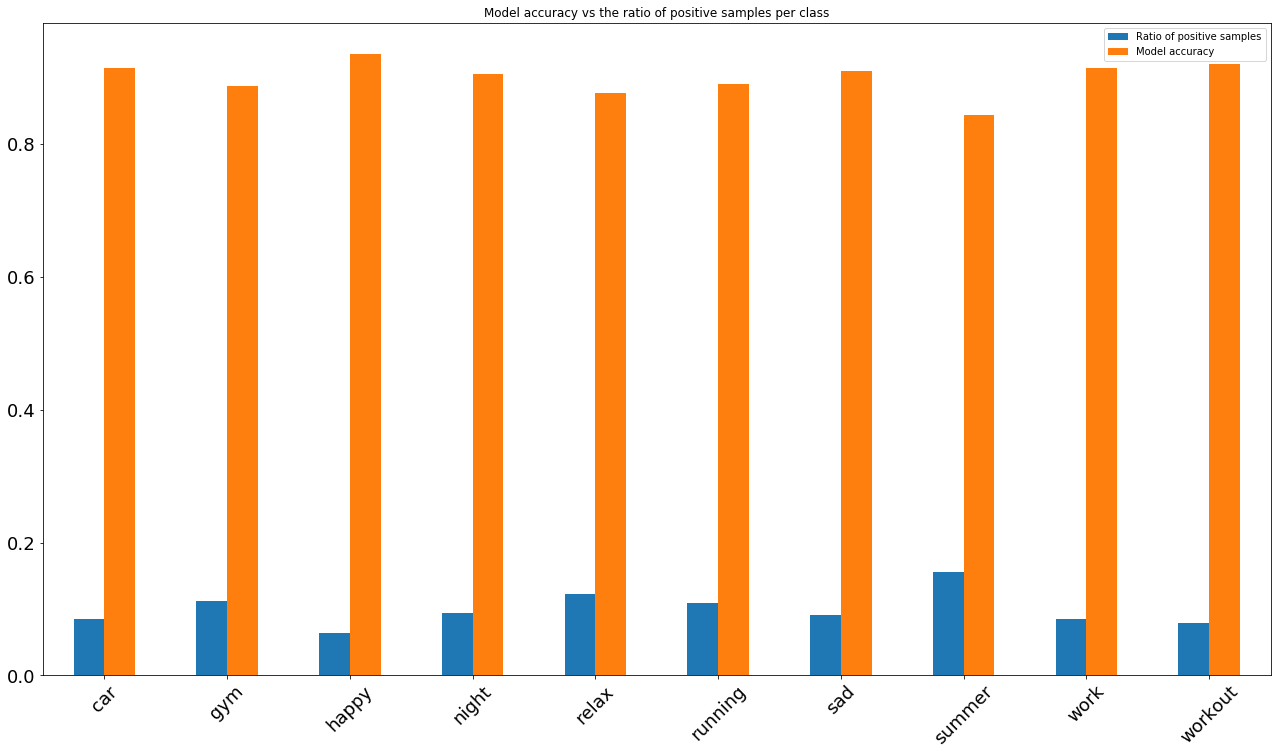

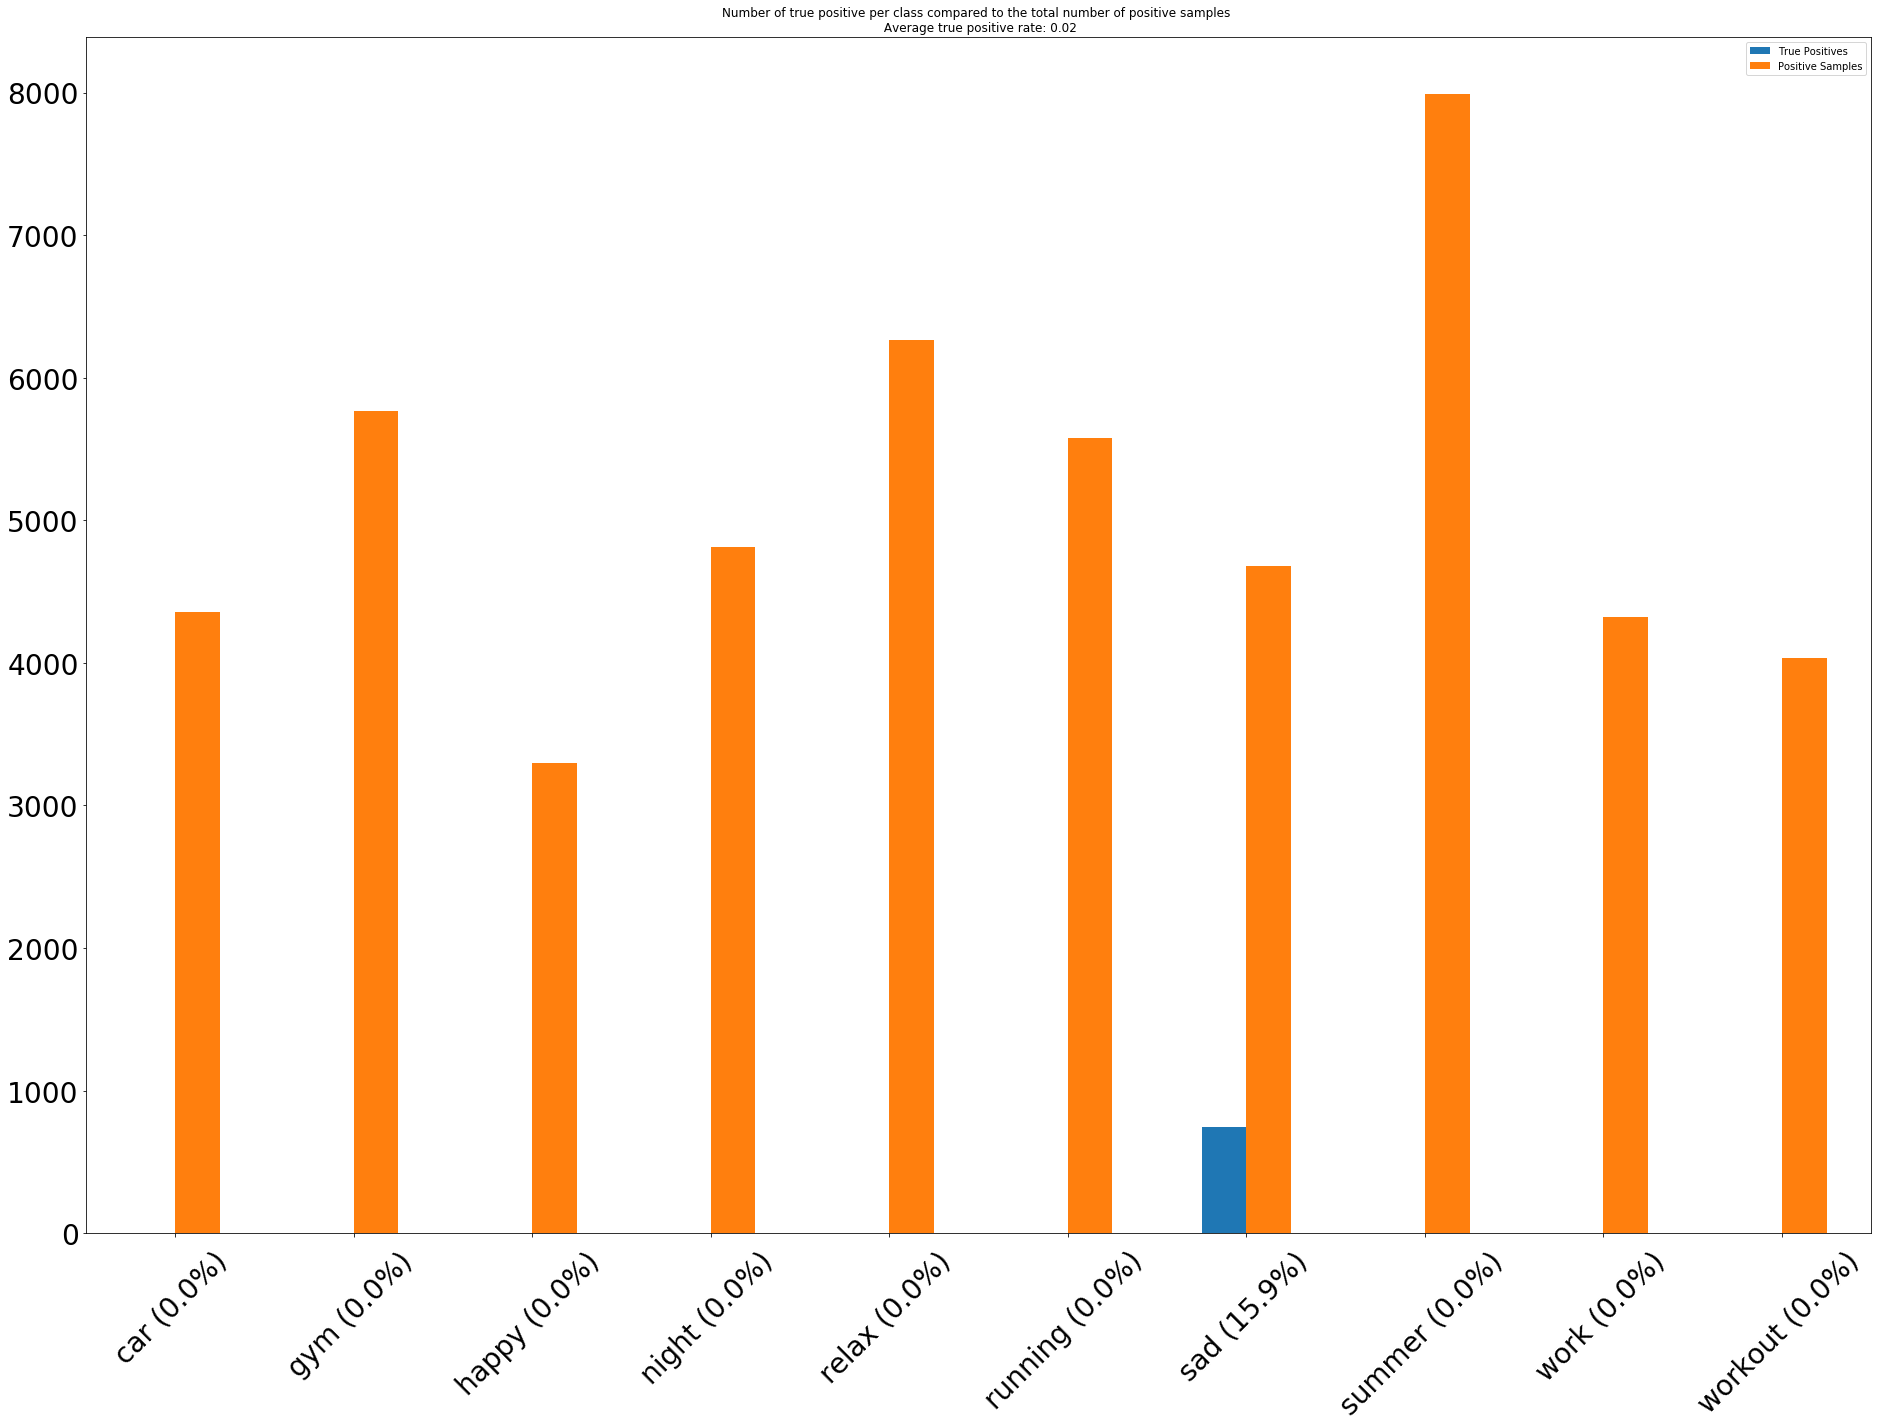

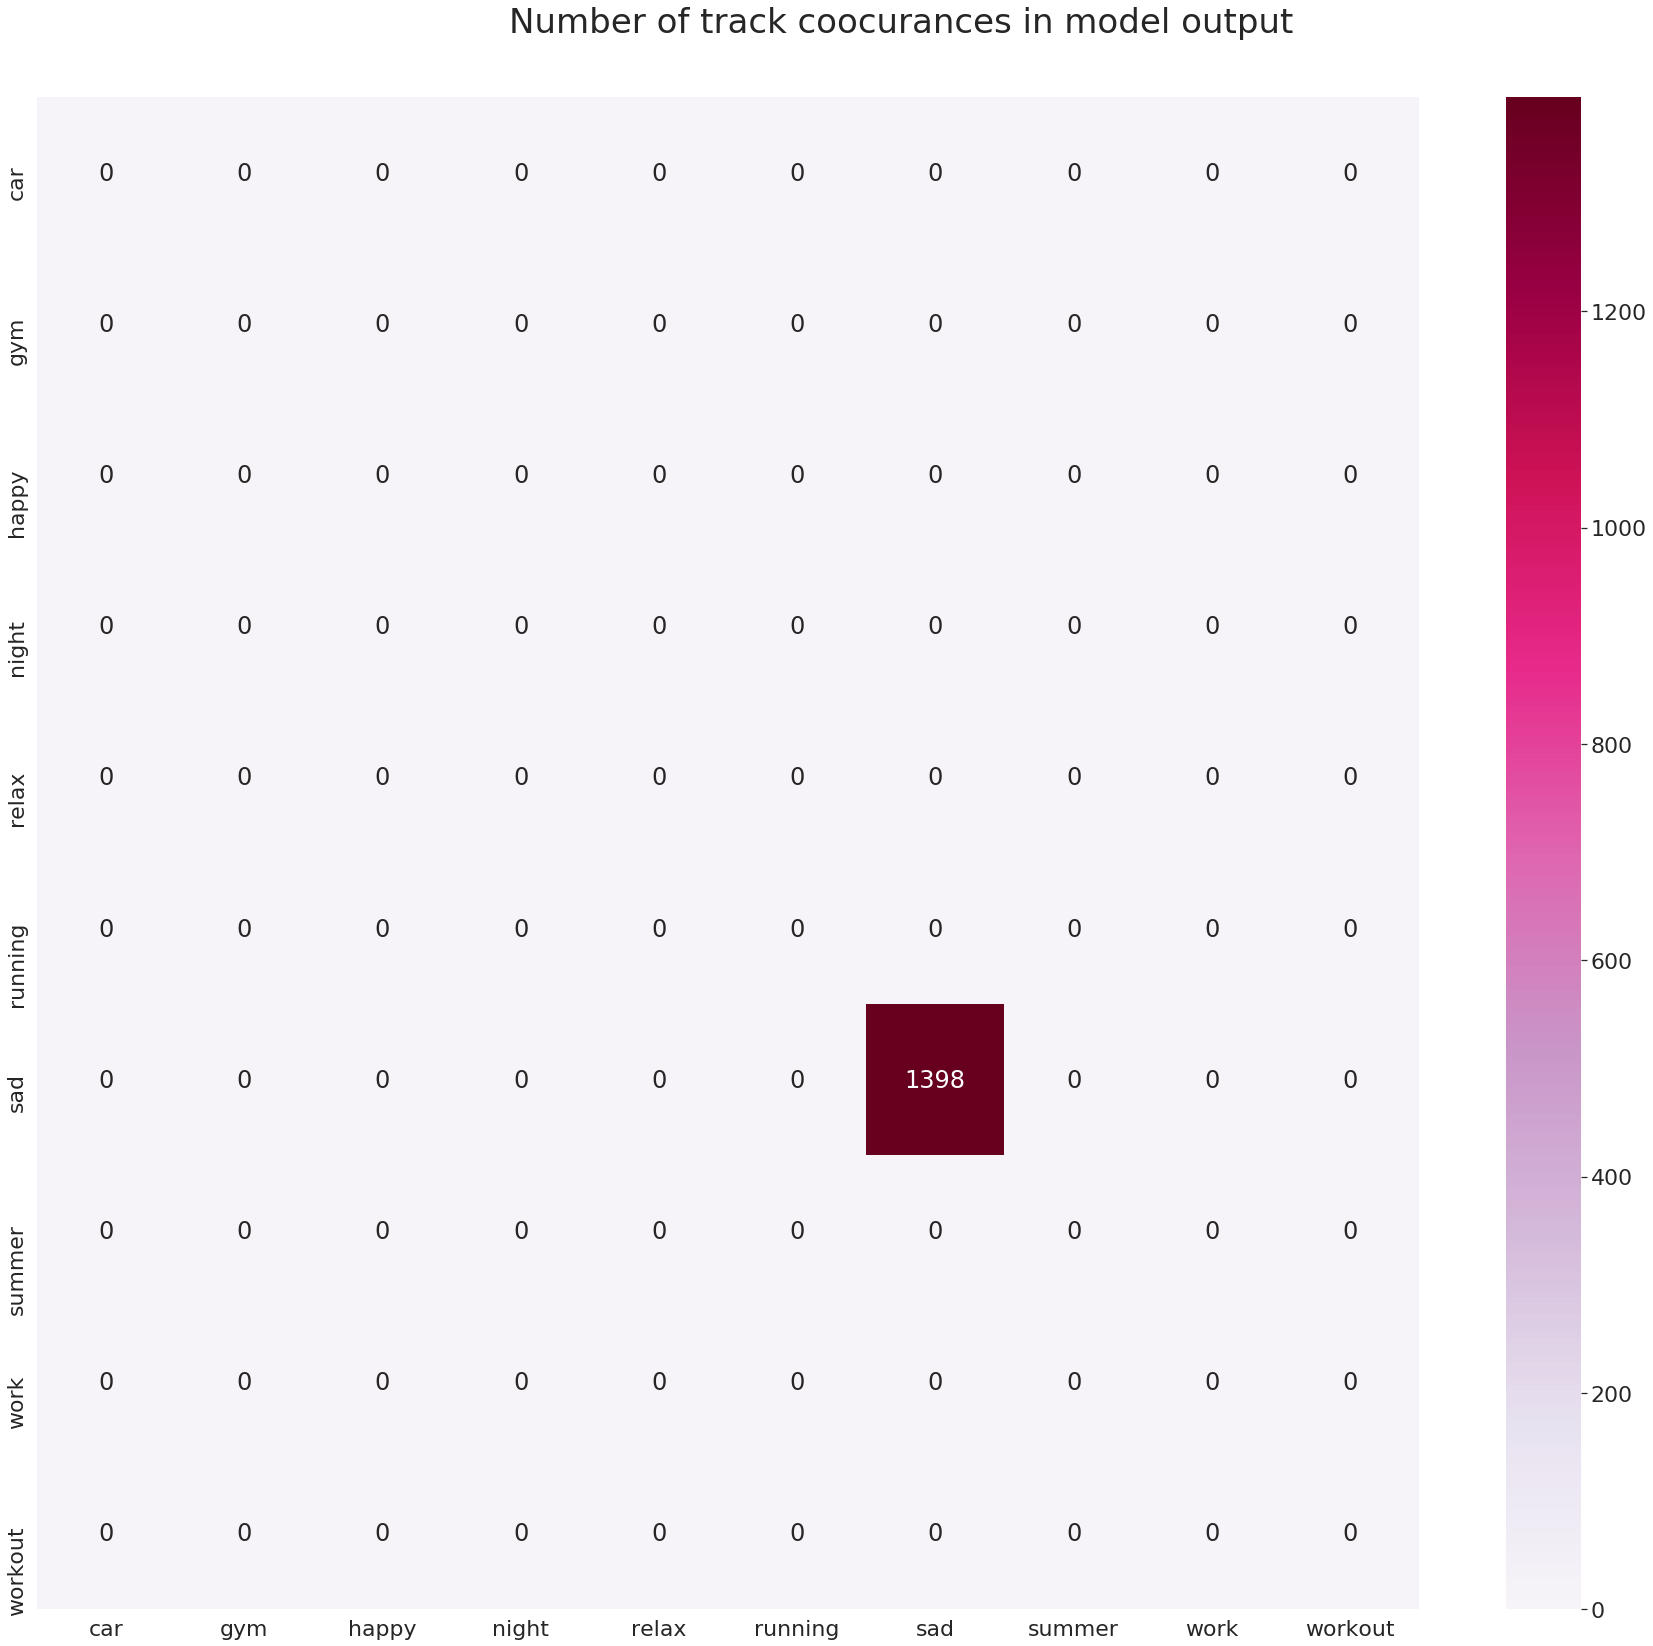

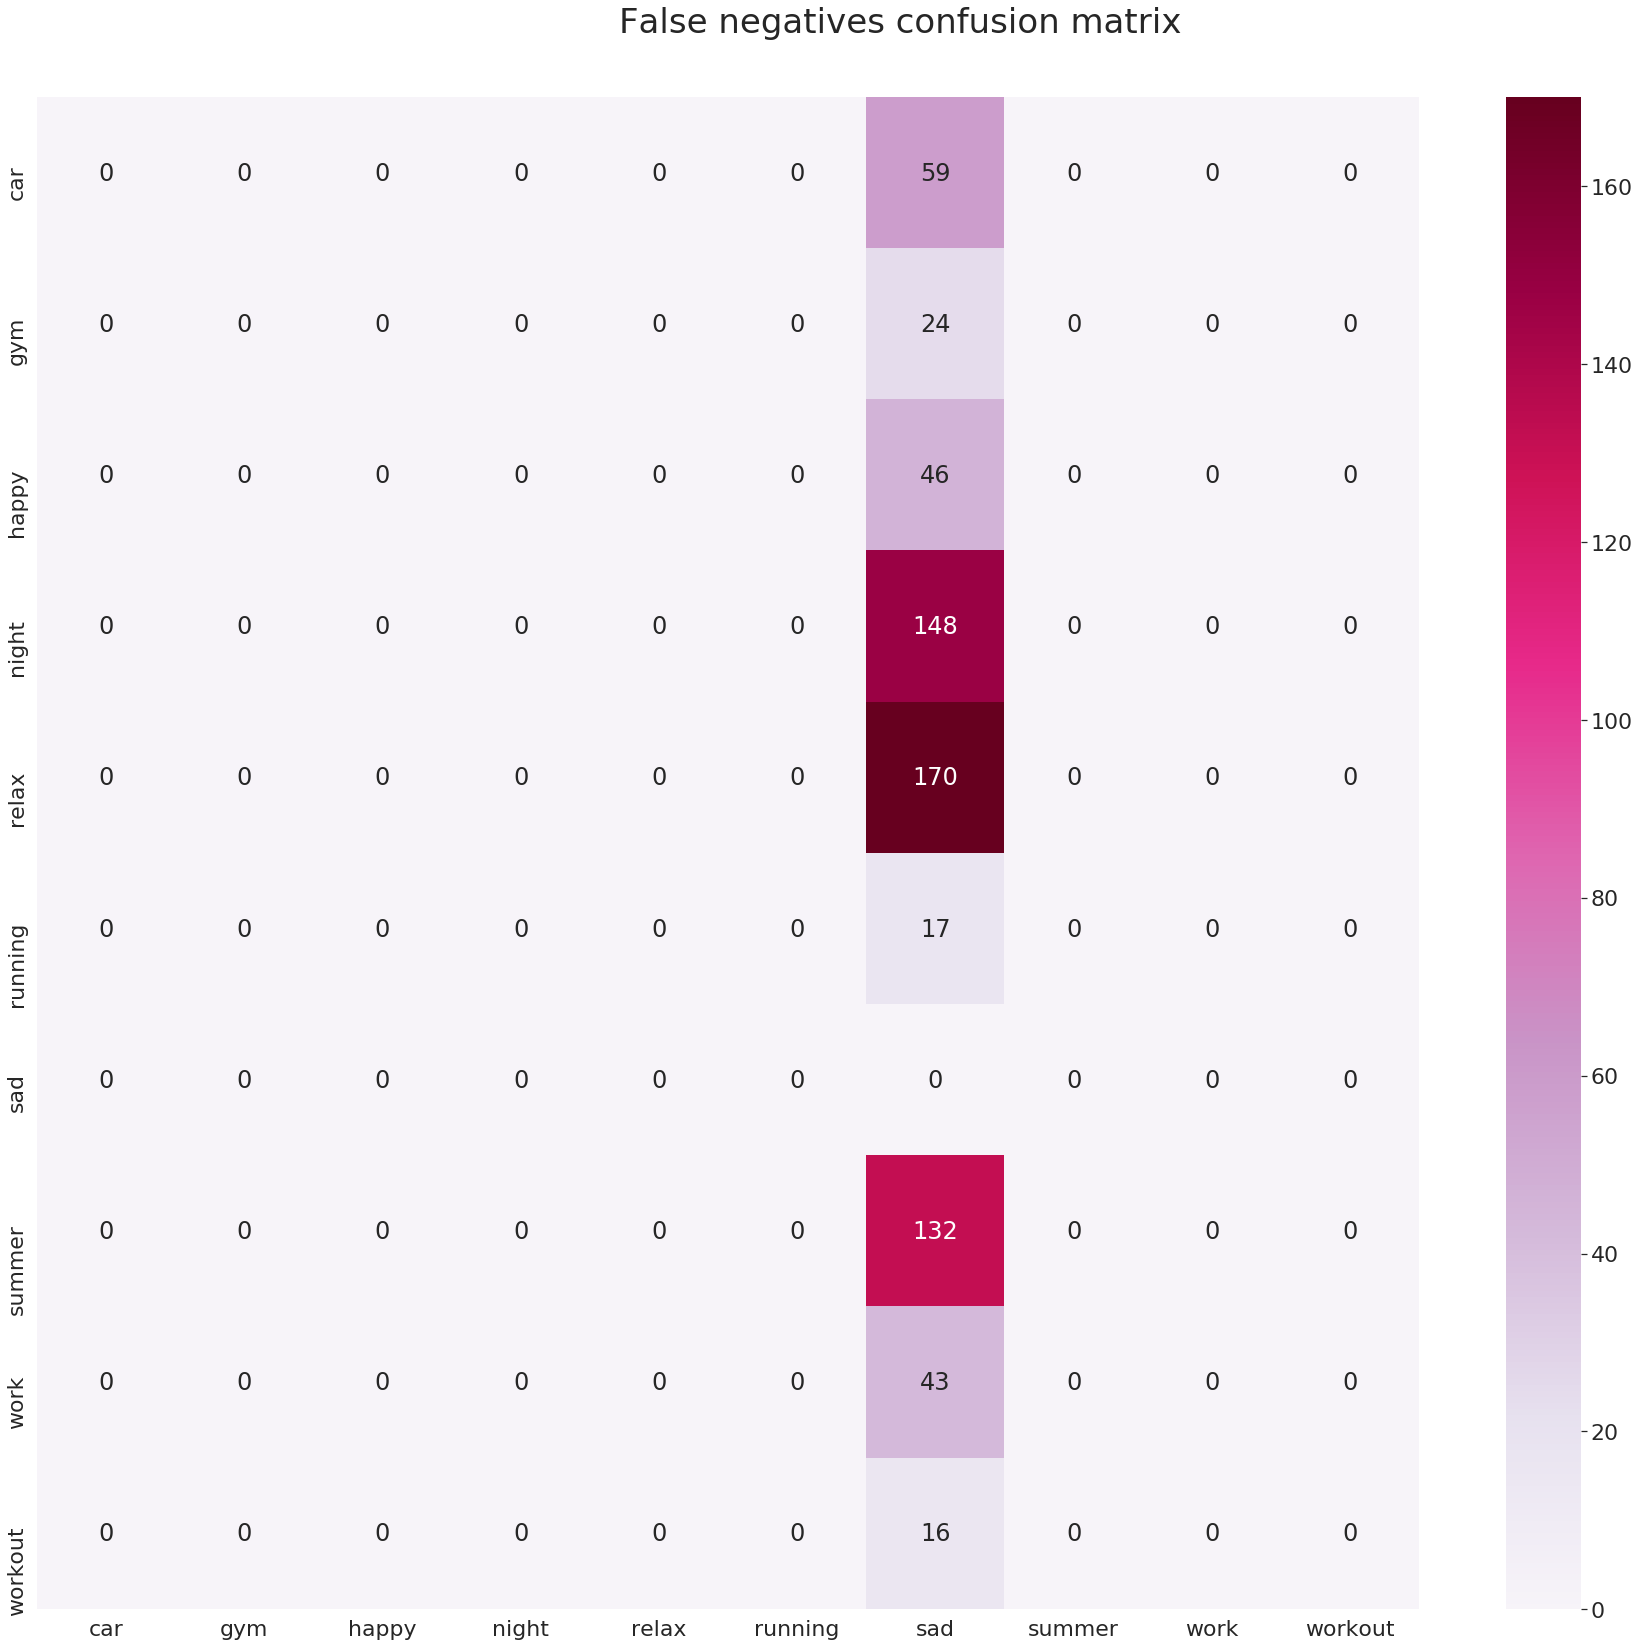

In [2]:
print("Current Experiment: " + EXPERIMENTNAME + "\n\n\n")
# Loading datasets
# TODO: fix directories

# Setting up model
y = tf.placeholder(tf.float32, [None, len(LABELS_LIST)], name="true_labels")
x_input = tf.placeholder(tf.float32, [None, 646, 96, 1], name="input")
embeddings_input = tf.placeholder(tf.float32, [None, EMBEDDINGS_DIM], name="input_embeddings")
current_keep_prob = tf.placeholder(tf.float32, name="dropout_rate")
weights = tf.constant(POS_WEIGHTS)
train_phase = tf.placeholder(tf.bool, name="is_training")
logits, model_output = get_model(x_input, embeddings_input, current_keep_prob, train_phase)
one_hot = tf.one_hot(tf.argmax(model_output, dimension = 1), depth = len(LABELS_LIST))

# Defining loss and metrics
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
'''
These following lines are needed for batch normalization to work properly
check https://timodenk.com/blog/tensorflow-batch-normalization/
'''
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# Setting up saving directory
experiment_name = strftime("%Y-%m-%d_%H-%M-%S", localtime())
exp_dir = os.path.join(OUTPUT_PATH, EXPERIMENTNAME, experiment_name)
extra_exp_dir =  os.path.join(EXTRA_OUTPUTS, EXPERIMENTNAME, "2020-05-07_18-19-37/")
os.makedirs(exp_dir, exist_ok=True)
saver = tf.train.Saver()
with tf.Session() as sess:
    # Write summaries to LOG_DIR -- used by TensorBoard
    sess.run(tf.global_variables_initializer())

    # Loading model with best validation
    saver.restore(sess, os.path.join(extra_exp_dir, "best_validation.ckpt"))
    print("Model with best validation restored before testing.")

    test_labels = pd.read_csv(os.path.join(SOURCE_PATH, "GroundTruth/test_single.csv"))
    test_dataset = get_dataset(os.path.join(SOURCE_PATH, "GroundTruth/test_single.csv"),shuffle = False)
    test_classes = np.zeros_like(test_labels.iloc[:, 2:].values, dtype=float)
    # test_images, test_classes = load_test_set_raw(test_split)

    TEST_NUM_STEPS = int(np.floor((len(test_classes) / 32)))
    # split_size = int(len(test_classes) / TEST_NUM_STEPS)
    test_pred_prob = np.zeros_like(test_classes, dtype=float)
    test_one_hot = np.zeros_like(test_classes, dtype=float)
    test_iterator = test_dataset.make_one_shot_iterator()
    test_next_element = test_iterator.get_next()
    test_song_ids = np.zeros([test_classes.shape[0],1])
    test_user_ids = np.zeros([test_classes.shape[0],1])

    for test_batch_counter in range(TEST_NUM_STEPS):
        start_idx = (test_batch_counter * BATCH_SIZE)
        end_idx = (test_batch_counter * BATCH_SIZE) + BATCH_SIZE
        test_batch = sess.run(test_next_element)
        test_batch_images = test_batch[0]
        test_batch_labels = np.squeeze(test_batch[1])
        test_embeddings = np.squeeze(test_batch[2])
        test_song_ids[start_idx:end_idx] = test_batch[3].reshape([-1, 1])
        test_user_ids[start_idx:end_idx] = test_batch[4].reshape([-1, 1])
        test_classes[start_idx:end_idx, :] = test_batch_labels

        test_pred_prob[start_idx:end_idx, :],test_one_hot[start_idx:end_idx, :] = sess.run([model_output, one_hot],
                                                        feed_dict={x_input: test_batch_images,
                                                                   embeddings_input: test_embeddings,
                                                                   current_keep_prob: 1.0,
                                                                   train_phase: False})


    np.savetxt(os.path.join(exp_dir, 'tracks_ids.txt'), test_song_ids, delimiter=',')
    np.savetxt(os.path.join(exp_dir, 'user_ids.txt'), test_user_ids, delimiter=',')
    np.savetxt(os.path.join(exp_dir, 'test_output_one_hot'), test_one_hot, delimiter=',')
    accuracy_out, auc_roc, hamming_error = evaluate_model(test_pred_prob, test_classes,
                                                          saving_path=exp_dir,
                                                          evaluation_file_path= \
                                                              os.path.join(exp_dir, "evaluation_results.txt"))
    results = create_analysis_report(test_one_hot, test_classes, exp_dir, LABELS_LIST)


In [6]:
# save as dataframe 
exp_dir = "/srv/workspace/research/user_based_contexts_tagging/experiments_results/single_label_deeper_weighted_normalized_long/2020-05-09_11-44-38"
test_ground_truth = pd.read_csv("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/test_single.csv")
test_groundtruth_from_model = np.loadtxt(exp_dir + "/test_ground_truth_classes.txt",delimiter=',')
user_ids = np.loadtxt(exp_dir + "/user_ids.txt",delimiter=',')
track_ids = np.loadtxt(exp_dir + "/tracks_ids.txt",delimiter=',')
test_output = np.loadtxt(exp_dir + "/predictions.out",delimiter=',')
test_output_one_hot = np.loadtxt(exp_dir + "/test_output_one_hot",delimiter=',')

In [7]:
our_ground_truth = test_ground_truth.copy()
our_ground_truth.song_id = track_ids
our_ground_truth.user_id = user_ids
our_ground_truth.iloc[:,2:] = test_groundtruth_from_model

In [8]:
our_predictions = test_ground_truth.copy()
our_predictions.song_id = track_ids
our_predictions.user_id = user_ids
our_predictions.iloc[:,2:] = test_output

output_one_hot = test_ground_truth.copy()
output_one_hot.song_id = track_ids
output_one_hot.user_id = user_ids
output_one_hot.iloc[:,2:] = test_output_one_hot

In [9]:
our_ground_truth.to_csv(exp_dir+"/groundtruth_withIDS.csv",index=False)
our_predictions.to_csv(exp_dir+"/probabilities_withIDS.csv",index=False)
output_one_hot.to_csv(exp_dir+"/onehot_withIDS.csv",index=False)

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(test_groundtruth_from_model, test_output_one_hot)

0.23982785602503912

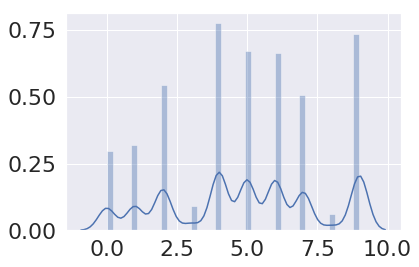

In [12]:
import seaborn as sns 
sns.distplot((np.argmax(our_predictions.values[:,2:],axis = 1)))

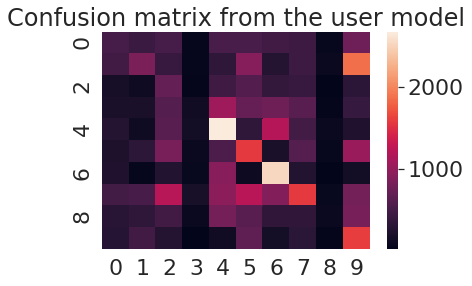

In [25]:
from sklearn.metrics import confusion_matrix
index_ground_truth = np.argmax(test_groundtruth_from_model,axis=1)
index_predictions = np.argmax(test_output_one_hot,axis=1)

cnf_mt = confusion_matrix(index_ground_truth, index_predictions)
plt.title("Confusion matrix from the user model")
sn.heatmap(cnf_mt)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(test_groundtruth_from_model, test_output_one_hot, target_names=LABELS_LIST))

              precision    recall  f1-score   support

         car       0.15      0.11      0.13      4355
         gym       0.24      0.15      0.18      5769
       happy       0.12      0.22      0.15      3299
       night       0.15      0.03      0.05      4814
       relax       0.31      0.43      0.36      6262
     running       0.22      0.28      0.24      5577
         sad       0.35      0.54      0.42      4678
      summer       0.28      0.20      0.23      7987
        work       0.13      0.02      0.04      4325
     workout       0.20      0.40      0.26      4038

   micro avg       0.24      0.24      0.24     51104
   macro avg       0.22      0.24      0.21     51104
weighted avg       0.23      0.24      0.22     51104
 samples avg       0.24      0.24      0.24     51104



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [ ]:
roc_auc_score(our_predictions.values[:,2:])